In [ ]:
!pip3 install --user sqlalchemy-redshift
!sudo `which pip3` install --upgrade  pandas==1.1.5

In [75]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from sqlalchemy import create_engine, text
import yaml
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Reading and exploting the raw data

<p><span style="font-weight: 400;">As our data scientist wants to start working on this project they initially obtain a dump of transactions with raw features from <span style="color: #ff6600;"><strong>AWS Redshift</strong></span>! Their initial goal is to explore the data and discover features that may prove as indicative for fraud.</span></p>
<p><span style="font-weight: 400;">The data scientists use <span style="color: #3366ff;">pandas</span> installed on <span style="color: #ff6600;">AWS SageMaker</span> notebook to read the file to the memory and start creating visualizations of the raw data with common python data science libraries such as <span style="color: #3366ff;">matplotlib</span> and <span style="color: #3366ff;">seaborn</span>.</span></p>

In [2]:
conf = yaml.load(open('./vars.yaml', 'r'))

In [3]:
rs_username = conf['REDSHIFT_USER']
rs_password = conf['REDSHIFT_PASSWORD']
rs_db = conf['REDSHIFT_DB']
rs_host = conf['REDSHIFT_HOST']

In [72]:
engine = create_engine(f'redshift+psycopg2://{rs_username}:{rs_password}@{rs_host}:5439/{rs_db}')

In [5]:
df = pd.read_sql('select * FROM raw_data', con=engine)

In [6]:
# Showing a sample of rows
df.sample(5)

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
299982,15,CASH_IN,234090.0,C1151099648,3759230.0,3993320.0,C1556828136,609745.0,375655.0,0,0
5452863,379,PAYMENT,7072.1,C536548543,0.0,0.0,M76536047,0.0,0.0,0,0
4721741,332,CASH_IN,71668.0,C683958101,2653710.0,2725380.0,C1496018595,431869.0,360201.0,0,0
3146738,237,PAYMENT,9092.0,C1795970007,10305.0,1213.0,M1437899408,0.0,0.0,0,0
2145396,184,TRANSFER,397922.0,C1360323851,0.0,0.0,C865628377,7310190.0,7270350.0,0,0


In [7]:
# Showing some stats of the dataset
df.describe()

,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924048e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338960e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487195e+04,1.420800e+04,0.000000e+00,1.327060e+05,2.146615e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087212e+05,1.073152e+05,1.442580e+05,9.430362e+05,1.111910e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244550e+07,5.958500e+07,4.958500e+07,3.560160e+08,3.561790e+08,1.000000e+00,1.000000e+00


In [8]:
# Looking for missing values
df.isnull().any()

step              False
type              False
amount            False
nameorig          False
oldbalanceorg     False
newbalanceorig    False
namedest          False
oldbalancedest    False
newbalancedest    False
isfraud           False
isflaggedfraud    False
dtype: bool

In [9]:
# Wow no missing values here!

<p><span style="font-weight: 400;">After identifying that the label that they are after is called "<strong>isFraud" </strong>the data science team would like to understand what is the scope of the fraud. They ask the following questions:</span></p>
<ol>
<li style="font-weight: 400;"><em><span style="font-weight: 400;">How many fraudulent transactions are we facing?&nbsp;</span></em></li>
<li style="font-weight: 400;"><em><span style="font-weight: 400;">What is the percentage of fraud and does it trend over time?</span></em></li>
<li style="font-weight: 400;"><em><span style="font-weight: 400;">How much money was involved in fraudulent transactions and what is it&rsquo;s portion of the entire turnout? </span></em></li>
</ol>


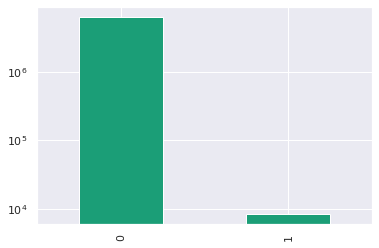

The portion of fraud transactions of all tranasctions is 0.13%


In [10]:
# what is the portion of fraudulent transaction? 
df['isfraud'].value_counts().plot(kind='bar', cmap='Dark2')
plt.yscale('log')
plt.show()
print(f"The portion of fraud transactions of all tranasctions is {round(df['isfraud'].mean()*100,2)}%")

### Does fraud trend over time?

In [11]:
df_ts = df.groupby('step').agg({'isfraud':['sum','count']}).sort_index()

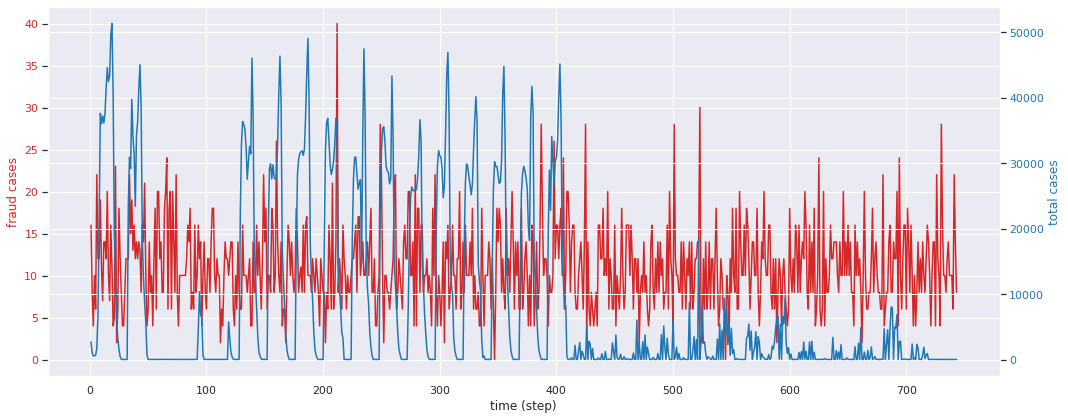

In [12]:
fig, ax1 = plt.subplots(figsize=(15,6))

color = 'tab:red'
ax1.set_xlabel('time (step)')
ax1.set_ylabel('fraud cases', color=color)
ax1.plot(df_ts.index, df_ts[('isfraud', 'sum')], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total cases', color=color)  # we already handled the x-label with ax1
ax2.plot(df_ts.index, df_ts[('isfraud', 'count')], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<p><span style="font-weight: 400;">No, it looks like the number of fraud cases doesn't increase over time</span></p>
<p><span style="font-weight: 400;">however...&nbsp;</span></p>
<p><span style="font-weight: 400;">The number of all transactions does decrease resulting in a higher rate of fraud!</span></p>

In [13]:
series_fraud_date = 100 * df_ts['isfraud']['sum'] /  df_ts['isfraud']['count']

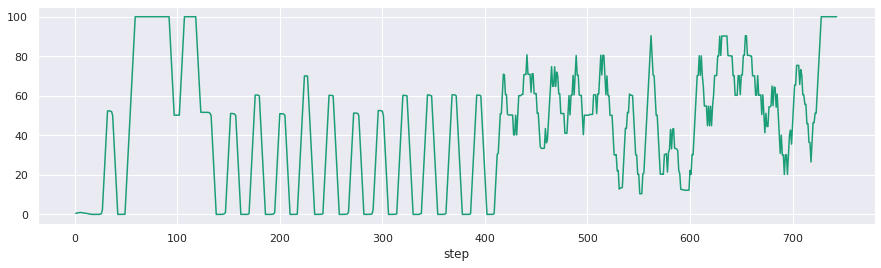

In [14]:
series_fraud_date.rolling(10, min_periods=1).mean().plot(figsize=(15,4), cmap='Dark2')
plt.show()

<p><strong>OK, wow.</strong><span style="font-weight: 400;"> While the general fraud rate is around </span><span style="font-weight: 400; color: #3366ff;">0.13%</span><span style="font-weight: 400;">, during some &ldquo;steps&rdquo; it can reach up to </span><span style="font-weight: 400; color: #ff0000;">100% </span><span style="font-weight: 400;">of the transactions...</span></p>

### IsFlaggedFraud 

<p><span style="font-weight: 400;">Our data scientists also notice that in the raw data there is a column named "<em><strong>isFlaggedFraud</strong>"</em>. They wonder of its about and learn that the company is using a 3rd party service that taggs suspected transactions. They are happy because now they have a benchmark to beat :) </span></p>

In [15]:
df[['isflaggedfraud', 'isfraud']].value_counts().reset_index()

,isflaggedfraud,isfraud,0
0,0,0,6354407
1,0,1,8197
2,1,1,16


In [16]:
df[['isflaggedfraud', 'isfraud']].corr()

,isflaggedfraud,isfraud
isflaggedfraud,1.000000,0.044109
isfraud,0.044109,1.000000


In [17]:
# Clearly the company wastes money on this service as it doesn't seem to correlate well with our target variable 

### Fraud by Transaction Type

<p><span style="font-weight: 400;">Off they go to start analyzing each feature individually. They start with the "<em><strong>T</strong><strong>ransaction Type</strong></em>" and quickly learn that there are some transaction types that are <span style="color: #ff0000;">much more prone to fraud</span>.</span></p>

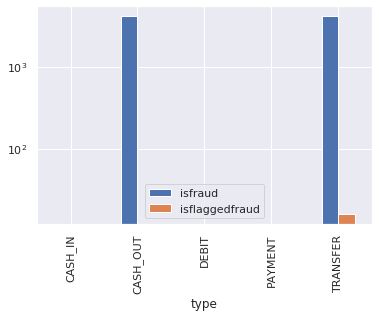

In [18]:
# fraud by transaction type
df.groupby('type').agg({'isfraud':'sum', 'isflaggedfraud':'sum'}).plot(kind='bar')
plt.yscale('log')
plt.show()

### Origin and destination accounts

<p><span style="font-weight: 400;">Obtaining access to a financial account requires going through authorization, making it an expensive process. Therefore we would like to check whether once an account (either destination or source) is involved with fraud it will be <span style="color: #ff0000;">reused</span>. On the other hand, a criminal that comes back to the crime scene isn&rsquo;t a smart criminal. </span></p>

In [19]:
df_origin_cases = df.groupby('nameorig', as_index=False).agg({'isfraud':'sum'}).sort_values('isfraud', ascending=False)
df_dest_cases =  df.groupby('namedest', as_index=False).agg({'isfraud':'sum'}).sort_values('isfraud', ascending=False)

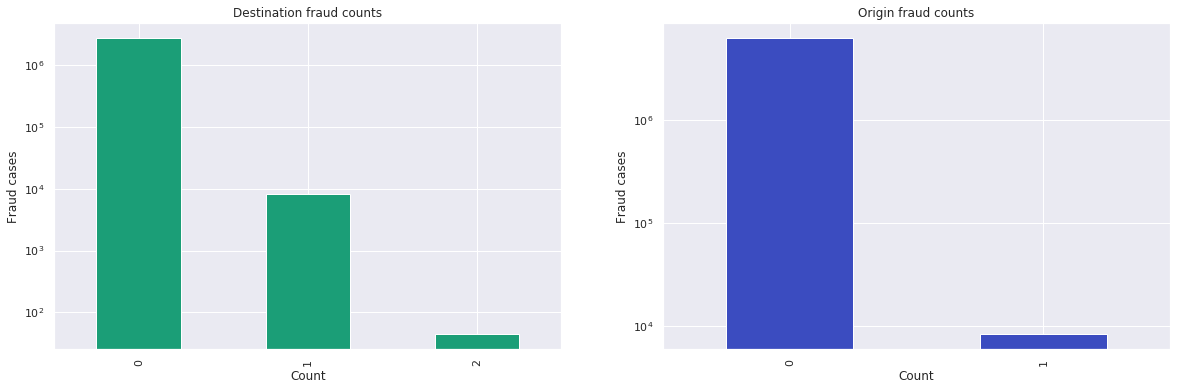

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ylab = 'Fraud cases'
xlab = 'Count'
df_dest_cases['isfraud'].value_counts().plot(kind='bar', ax=ax[0],
                                             title='Destination fraud counts',
                                             xlabel=xlab, ylabel=ylab, cmap='Dark2')

df_origin_cases['isfraud'].value_counts().plot(kind='bar', ax=ax[1],
                                               title='Origin fraud counts',
                                               xlabel=xlab, ylabel=ylab, cmap='coolwarm')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.show()

<p>It looks like for origin accounts there is<strong> not a single "second fraud case"</strong>, destination accounts do have "second cases" but they are very rare, <strong><span style="color: #339966;">most destination accounts with fraud have only one case</span></strong>.</p>

## Fraud by transaction amount 

<p><span style="font-weight: 400;">The data science team thinks of what other features may be relevant for their model. They would like to analyze the <span style="color: #800080;"><strong>transaction amount</strong> </span>by plotting the <span style="color: #800080;">histograms</span> of <span style="color: #3366ff;">fraud</span> and <span style="color: #ff6600;">non-fraud</span> transaction amount over each other.&nbsp;</span></p>

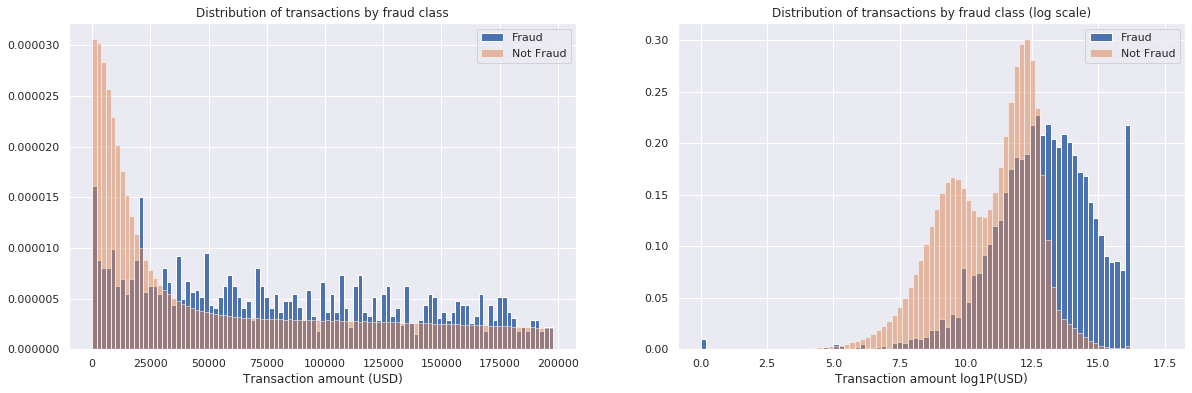

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))


ax[0].hist(df['amount'][df['isfraud']==True], bins=range(0,int(2e5),2000), density=True, label='Fraud')
ax[0].hist(df['amount'][df['isfraud']==False], bins=range(0,int(2e5),2000), alpha=0.5, density=True, label='Not Fraud')
ax[0].set_title('Distribution of transactions by fraud class')
ax[0].legend()
ax[0].set_xlabel("Transaction amount (USD)")


ax[1].hist(df['amount'][df['isfraud']==True].apply(np.log1p), bins=np.arange(0,17.5,0.2), density=True, label='Fraud')
ax[1].hist(df['amount'][df['isfraud']==False].apply(np.log1p), bins=np.arange(0,17.5,0.2), alpha=0.5, density=True, label='Not Fraud')

ax[1].set_title('Distribution of transactions by fraud class (log scale)')
ax[1].legend()
ax[1].set_xlabel("Transaction amount log1P(USD)")


plt.show()


<p><span style="font-weight: 400;">The team feels </span><span style="font-weight: 400; font-size: 20px;">lucky!</span><span style="font-weight: 400;"> They have found a strong differentiator between fraud and legitimate transactions. it is of course the transaction amount. They plan to use <span style="color: #3366ff;"><strong>log1p(amount)</strong></span>&nbsp;as a feature for their model.</span></p>

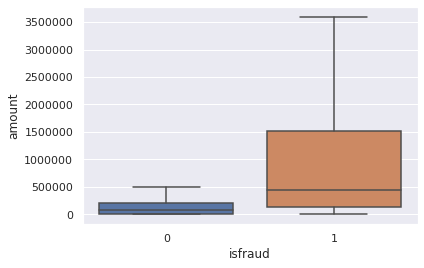

In [22]:
# It's very observable when looking at this boxplot
sns.boxplot(data=df, y='amount', x='isfraud', showfliers=False)
plt.show()

##  Other numeric features

In [23]:
df['diff_origin_equal_amount'] = (df['oldbalanceorg'] - df['newbalanceorig']).abs() == df['amount']
df['diff_dest_equal_amount'] = (df['oldbalancedest'] - df['newbalancedest']).abs() == df['amount']

In [24]:
df.columns

Index(['step', 'type', 'amount', 'nameorig', 'oldbalanceorg', 'newbalanceorig',
       'namedest', 'oldbalancedest', 'newbalancedest', 'isfraud',
       'isflaggedfraud', 'diff_origin_equal_amount', 'diff_dest_equal_amount'],
      dtype='object')

In [25]:
num_features_to_plot = ['oldbalanceorg', 'newbalanceorig', 'oldbalancedest',
                        'newbalancedest', 'diff_origin_equal_amount', 'diff_dest_equal_amount']


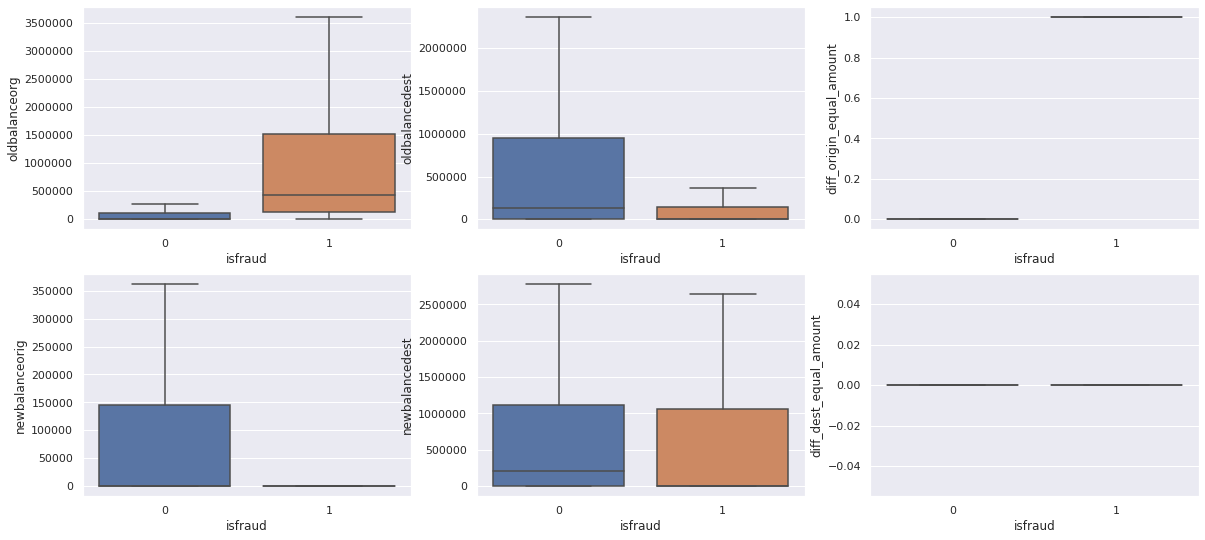

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,9))
plot_i = 0
for feature_to_plot in num_features_to_plot:
    row = int(plot_i/2)
    col = plot_i % 2
    sns.boxplot(data=df, y=feature_to_plot, x='isfraud', showfliers=False, ax=ax[col, row])
    plot_i += 1
plt.show()

<p><span style="font-weight: 400;">The data clearly shows some interesting points:</span></p>
<ol>
<li><span style="font-weight: 400;"> For all fraud cases the <span style="color: #339966;"><strong>new origin balance is 0!</strong></span> meaning, that if money leaves for fraud they take it all</span></li>
<li><span style="font-weight: 400;"> The old balance of destination fraud accounts is significantly <span style="color: #339966;"><strong>lower</strong></span>&nbsp;</span></li>
<li><span style="font-weight: 400;"> Fraud cases involve <strong><span style="color: #339966;">much higher</span></strong> balance origin accounts&nbsp;</span></li>
<li><span style="font-weight: 400;">Only in fraud cases there is a <strong><span style="color: #339966;">difference in the calculated transaction amount vs the decaled amount</span></strong></span></li>
</ol>

## Account ID (Name) 

<p><span style="font-weight: 400;">Our team have noticed that some of the features are categorical and cannot be sent to the model as-is. they decided to handle the categorical feature as follows:</span></p>
<ol>
<li style="font-weight: 400;"><span style="font-weight: 400;">From the accounts names they <span style="color: #008000;"><strong>extract the initial character</strong></span> indicating whether the account is of type "M" or "C"</span></li>
<li style="font-weight: 400;"><span style="font-weight: 400;">The transaction type is going to be transformed to <span style="color: #3366ff;"><strong>1-hot encoding</strong></span></span></li>
</ol>

In [31]:
# What values does the first char of the account name has?
print(df['nameorig'].apply(lambda x: x[0]).unique())
print(df['namedest'].apply(lambda x: x[0]).unique())

['C']
['M' 'C']


In [28]:
df['nameorig_C'] = (df['nameorig'].apply(lambda x: x[0]) == 'C').astype(int)
df['namedest_C'] = (df['namedest'].apply(lambda x: x[0]) == 'C').astype(int)

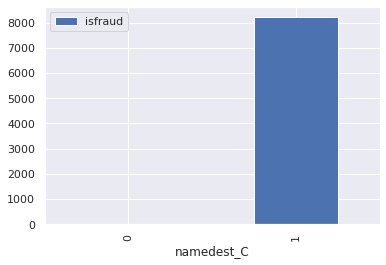

In [41]:
# Looks like fraud events only occur in C type destination accounts!
df.groupby('namedest_C').agg({'isfraud':sum}).plot(kind='bar')
plt.show()

In [29]:
payment_types = df['type'].unique()
for payment_type in payment_types:
    df[f'is_{payment_type.lower()}'] = (df['type'] == payment_type).astype(int)

# Feature transformations as a conclusion of the EDA

<p><span style="font-weight: 400;">Our data science team decided to implement the following feature transformations:</span></p>
<ol>
<li style="font-weight: 400;"><span style="font-weight: 400;">Apply </span><strong><span style="color: #3366ff;">log1p transformation</span></strong><span style="font-weight: 400;"> on the following features to bring them closer to gaussian form: </span><span style="color: #ff6600;"><strong>amount</strong><span style="font-weight: 400;">, </span><strong>oldbalanceorg</strong><span style="font-weight: 400;">, </span><strong>newbalanceorig</strong><span style="font-weight: 400;">, </span><strong>oldbalancedest</strong><span style="font-weight: 400;">, </span><strong>newbalancedest</strong><span style="font-weight: 400;">.</span></span></li>
<li style="font-weight: 400;"><span style="font-weight: 400;">Calculate two </span><span style="color: #3366ff;"><strong>binary features</strong></span><span style="font-weight: 400;"> that indicate if the difference between the old and new balances equal the declared amount </span><span style="color: #ff6600;"><strong>diff_origin_equal_amount</strong><span style="font-weight: 400;">, </span><strong>diff_dest_equal_amount</strong></span></li>
<li style="font-weight: 400;"><span style="font-weight: 400;">Create two </span><span style="color: #3366ff;"><strong>binary features</strong></span><span style="font-weight: 400;"> that indicate if the account (origin or destination) is of type "C": </span><span style="color: #ff6600;"><strong>'nameorig_C'</strong><span style="font-weight: 400;">, </span><strong>namedest_C</strong></span></li>
<li style="font-weight: 400;"><span style="font-weight: 400;">Generate </span><strong>o<span style="color: #3366ff;">ne-hot encoding</span></strong><span style="font-weight: 400;"> from the transaction type: </span><span style="color: #ff6600;"><strong>i</strong><strong>s_payment</strong><span style="font-weight: 400;">, </span><strong>is_transfer</strong><span style="font-weight: 400;">, </span><strong>is_debit</strong><span style="font-weight: 400;">, </span><strong>is_cash_out</strong><span style="font-weight: 400;">, </span><strong>is_cash_in</strong></span></li>
<li style="font-weight: 400;"><span style="font-weight: 400;">Use </span><strong>isfraud</strong><span style="font-weight: 400;"> as the<span style="color: #3366ff;"> target variable</span> for binary classification</span></li>
<li style="font-weight: 400;"><span style="color: #3366ff;"><strong>Remove features</strong> </span>that were either represented before or can cause overfitting: <span style="color: #ff6600;"><strong>namedest</strong>, <strong>nameorig</strong>, <strong>type</strong>, <strong>step</strong></span></li>
</ol>

# Generating the dataset 

<p><span style="font-weight: 400;">Now, after performing a process of EDA the team wishes to start training the model! But before they can do that, they would like to write the feature transformation code in <span style="color: #ff00ff;"><strong>SQL</strong></span>. They do it assuming that it will allow then to leverage <span style="color: #ff6600;"><strong>AWS Redshift</strong></span> to perform the transformations on massive datasets in the future and also use the same code for online inference with&nbsp;<strong><span style="color: #ff6600;">Amazon Kinesis Data Analytics SQL</span></strong><span style="color: #ff6600;"><span style="color: #000000;"> (will not be implemented as part of the capstone)</span></span></span></p>

In [67]:
query_feature_extraction = '''
select
--target variable
  isfraud
-- log transformed features
, (LOG(amount+1)) as amount
, (LOG(oldbalanceorg+1)) as oldbalanceorg
, (LOG(newbalanceorig+1)) as newbalanceorig
, (LOG(oldbalancedest+1)) as oldbalancedest
, (LOG(newbalancedest+1)) as newbalancedest

-- binary boolean features
, CAST (nameorig like 'C%' as int) nameorig_C
, CAST (namedest like 'C%' as int) namedest_C
, CASE ABS(oldbalanceorg - newbalanceorig) WHEN amount THEN 1 ELSE 0 END diff_origin_equal_amount
, CASE ABS(oldbalancedest - newbalancedest) WHEN amount THEN 1 ELSE 0 END diff_dest_equal_amount

-- payment type 1-hot encoding
 , CASE type WHEN 'PAYMENT' THEN 1 ELSE 0 END is_payment
, CASE type WHEN 'TRANSFER' THEN 1 ELSE 0 END is_transfer
, CASE type WHEN 'DEBIT' THEN 1 ELSE 0 END is_debit
, CASE type WHEN 'CASH_OUT' THEN 1 ELSE 0 END is_cash_out
, CASE type WHEN 'CASH_IN' THEN 1 ELSE 0 END is_cash_in

-- time variable
, step
FROM raw_data

'''

In [68]:
query_create_table = f'''
create table dataset as {query_feature_extraction};
'''

In [73]:
connection = engine.connect()
results = connection.execute(text(query_create_table))